In [1]:
# Imports
import torch
import time
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader , random_split
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Define hyperparameters
Batch_size = 256
Random_seed = 22
Num_epochs = 15

# Set random seed for reproducibility
torch.manual_seed(Random_seed)
generator1 = torch.Generator().manual_seed(Random_seed)

# Gpu support
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Transformation to resize Mnist image to 32 X 32 and also Normalize
transformation = transforms.Compose([transforms.Resize(( 32, 32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean = 0.5, std = 0.5)])

In [4]:
# Download dataset
train_dataset = datasets.MNIST(root = 'data',
                               train = True,
                               download =True,
                               transform=transformation)

test_dataset = datasets.MNIST(root = 'data',
                              train = False,
                              transform=transformation)

In [5]:
# Create Validation set
validation_size= int(0.1* (len(train_dataset)))
train_size = int(len(train_dataset) - validation_size)
train_dataset, valid_dataset = random_split(train_dataset, [train_size, validation_size], generator=generator1)

In [6]:
# Load datasets into Dataloader for iterating over the datasets
train_loader = DataLoader(train_dataset, batch_size = Batch_size, shuffle=True, drop_last=True,)
valid_loader = DataLoader(valid_dataset, batch_size = Batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = Batch_size, shuffle=False)


In [7]:
# Check trainloader
for features, labels in train_loader:
    print(f'Image Dimensions {features.shape}')
    print(f'Labels Dimensions {labels.shape}')
    print(f'Class labels of 10 examples - {labels[:10]}')
    break


Image Dimensions torch.Size([256, 1, 32, 32])
Labels Dimensions torch.Size([256])
Class labels of 10 examples - tensor([6, 4, 7, 1, 1, 0, 3, 9, 3, 3])


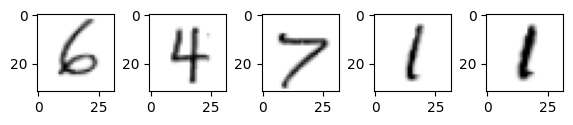

In [8]:
# check some images
fig, ax = plt.subplots(1, 5, figsize =(7, 1))
for i in range(5):
    ax[i].imshow(features[i].reshape(32, 32), cmap = 'binary')

In [9]:
# Lenet-5 Model
class lenet5(torch.nn.Module):
    def __init__(self, num_classes, greyscale = False):
        super().__init__()

        self.greyscale = greyscale
        self.num_classes = num_classes

        if self.greyscale:
            in_channels = 1
        else:
            in_channels = 3

        # Convolutional layers
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, 6 , kernel_size = 5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size = 2),
            torch.nn.Conv2d(6, 16, kernel_size=5),
            torch.nn.Tanh(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        # Fully connected layers
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(16*5*5, 120),
            torch.nn.Tanh(),
            torch.nn.Linear(120, 84),
            torch.nn.Tanh(),
            torch.nn.Linear(84, self.num_classes)
        )

    # Forward pass
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits

In [10]:
# Initialise model
model= lenet5(num_classes = 10, greyscale = True)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

In [11]:
# Define accuracy function
def compute_accuracy(model, data_loader):
    correct, num_examples = 0, 0
    for features, labels in data_loader:
        features = features.to(device)
        labels = labels.to(device)
        logits = model(features)
        predicted_labels = torch.argmax(logits, dim=1)
        correct += (predicted_labels == labels).sum().item()
        num_examples += labels.size(0)
    return (correct / num_examples) * 100


In [12]:
  # Training the Model

mini_batch_loss, train_acc_list, valid_acc_list = [], [], []

start_time = time.time()
for epoch in range(Num_epochs):
    model.train()  # set model in train mode
    for batch_idx, (features, label) in enumerate(train_loader):

        features = features.to(device)
        label = label.to(device)

        # Compute logits
        logits = model(features)
        # Compute loss
        loss = F.cross_entropy(logits, label)
        optimizer.zero_grad()
        # Backprops
        loss.backward()
        # Update gradient
        optimizer.step()

        # Logging
        mini_batch_loss.append(loss.item())
        if batch_idx % 50 ==0 :
           print(f'Epoch : {epoch + 1:03d}/{Num_epochs:03d} | Batch {batch_idx:03d}/{len(train_loader)} | Loss : {loss.item():.3f}')

    model.eval()
    with torch.no_grad():  # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        valid_acc = compute_accuracy(model, valid_loader)
        print(f'Epoch : {epoch+1:03d}/{Num_epochs:03d} | Train: {train_acc :.2f}% | Validation: {valid_acc :.2f}%')
        print(f'Time elapsed: {(((time.time() - start_time)/60)):.2f} min')
        train_acc_list.append(train_acc)
        valid_acc_list.append(valid_acc)

    # lR scheduler
    scheduler.step(valid_acc_list[-1])

total_time_elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {total_time_elapsed:.2f} min')

test_acc = compute_accuracy(model, test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch : 001/015 | Batch 000/210 | Loss : 2.290
Epoch : 001/015 | Batch 050/210 | Loss : 0.918
Epoch : 001/015 | Batch 100/210 | Loss : 0.645
Epoch : 001/015 | Batch 150/210 | Loss : 0.349
Epoch : 001/015 | Batch 200/210 | Loss : 0.235
Epoch : 001/015 | Train: 92.42% | Validation: 93.10%
Time elapsed: 0.62 min
Epoch : 002/015 | Batch 000/210 | Loss : 0.256
Epoch : 002/015 | Batch 050/210 | Loss : 0.218
Epoch : 002/015 | Batch 100/210 | Loss : 0.172
Epoch : 002/015 | Batch 150/210 | Loss : 0.223
Epoch : 002/015 | Batch 200/210 | Loss : 0.164
Epoch : 002/015 | Train: 95.81% | Validation: 95.83%
Time elapsed: 1.09 min
Epoch : 003/015 | Batch 000/210 | Loss : 0.212
Epoch : 003/015 | Batch 050/210 | Loss : 0.153
Epoch : 003/015 | Batch 100/210 | Loss : 0.111
Epoch : 003/015 | Batch 150/210 | Loss : 0.121
Epoch : 003/015 | Batch 200/210 | Loss : 0.080
Epoch : 003/015 | Train: 96.97% | Validation: 96.83%
Time elapsed: 1.60 min
Epoch : 004/015 | Batch 000/210 | Loss : 0.108
Epoch : 004/015 | Ba

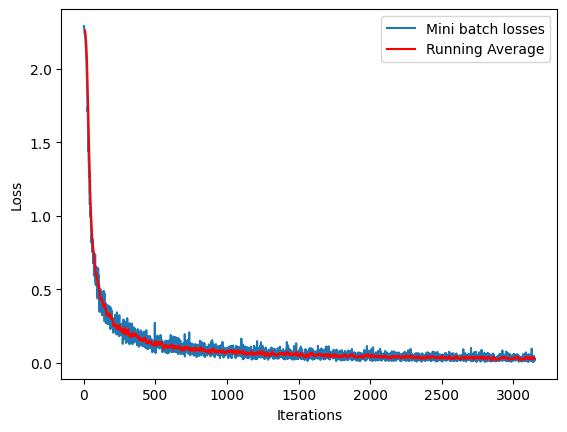

In [13]:
# Get running average
def running_average(data, window_size):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

# Calculate the running average of minibatch loss
window_size = 10
avg_losses = running_average(mini_batch_loss, window_size)

# Plotting
plt.plot(mini_batch_loss, label='Mini batch losses')
plt.plot(np.arange(window_size - 1, len(mini_batch_loss)), avg_losses, label='Running Average', color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

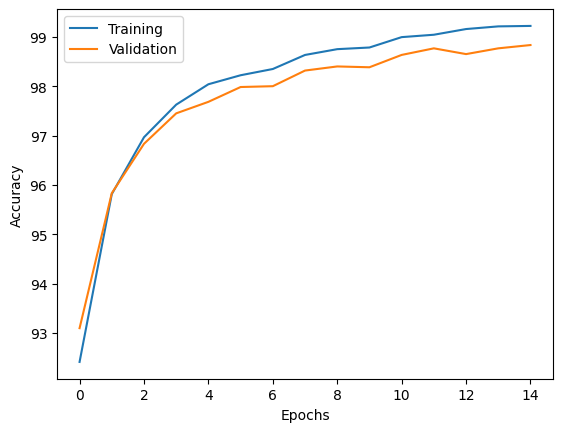

In [14]:
# Plot of train and validation accuracies
plt.plot(train_acc_list, label='Training')
plt.plot(valid_acc_list, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()